The point of this notebook is to try to group together the time buckets based on similar mean and standard deviation of the Lat/lon of the RTAs that occur in the bucket.
I use a clustering technique to see if the mean/stdev combinations can be grouped effectively

In [ ]:
import pandas as pd
import numpy as np
import re
import datetime
import math
from sklearn.cluster import KMeans
import geopandas as gpd
import h3 # h3 bins from uber
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch


In [ ]:
def create_crash_df(train_file = '../Inputs/Train.csv'):  
    crash_df = pd.read_csv(train_file, parse_dates=['datetime'])
    return crash_df

def create_temporal_features(df):
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 6: "15-18", 7: "18-21", 8: "21-24"}
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
               7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    
    df["time_window"] = df["datetime"].apply(lambda x: math.floor(x.hour / 3) + 1)
    df["time_window_str"] = df["time_window"].apply(lambda x: dict_windows.get(x))
    df["day"] = df["datetime"].apply(lambda x: x.day)
    df["month"] = df["datetime"].apply(lambda x: dict_months.get(x.month))
    df["year"] = df["datetime"].apply(lambda x: x.year)
    df["weekday"] = df["datetime"].apply(lambda x: x.weekday())
    return df

def assign_hex_bin(df,lat_column="latitude",lon_column="longitude"):
    df["h3_zone_5"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 5),axis=1)
    df["h3_zone_6"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 6),axis=1)
    df["h3_zone_7"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 7),axis=1)
    return df

In [ ]:
# load data and apply feautre engineering, drop unnessecary columns
crash_df = create_crash_df(train_file = '../nairobi-capstone/Inputs/Train.csv')
crash_df = create_temporal_features(crash_df)
crash_df = assign_hex_bin(crash_df)
#crash_df = crash_df.drop(['uid','day','year','time_window','datetime'], axis=1)
#crash_df = crash_df.drop(['uid','day','year','time_window','datetime','month'], axis=1)
# group by identified seasonal features, get aggregate values for these groups
crash_group = crash_df.groupby(['time_window_str', 'weekday','month'])
#display(crash_group.head())
group_stats = crash_group.agg({'latitude': [np.mean, np.std],'longitude': [np.mean, np.std, 'count']})
# flatten out groupby object and rename columns
group_stats = group_stats.reset_index()
group_stats.columns = group_stats.columns.get_level_values(0)
group_stats.columns.values[[3,4,5,6,7]] = ['latitude_mean', 'latitude_std','longitude_mean', 'longitude_std','RTA_count']
group_stats.dropna(inplace=True)
display(group_stats.head(30))
group_stats.shape

,time_window_str,weekday,month,latitude_mean,latitude_std,longitude_mean,longitude_std,RTA_count
0,00-03,0,Apr,-1.211776,0.132891,36.917947,0.128711,2
2,00-03,0,Feb,-1.242684,0.045773,36.842321,0.062620,20
3,00-03,0,Jan,-1.254819,0.165771,36.847736,0.104125,30
4,00-03,0,Jun,-1.295523,0.108125,36.775087,0.165036,2
5,00-03,0,Mar,-1.253387,0.062545,36.856749,0.070285,14
6,00-03,0,May,-1.316585,0.000000,36.833825,0.000000,2
8,00-03,1,Apr,-1.208171,0.000000,36.926621,0.000000,2
10,00-03,1,Feb,-1.244637,0.049286,36.851236,0.072177,18
11,00-03,1,Jan,-1.247215,0.082380,36.883298,0.082564,13
13,00-03,1,Mar,-1.956385,1.005768,37.393845,0.686806,2


(567, 8)

In [ ]:
group_stats.h3_zone_6.nunique()

117

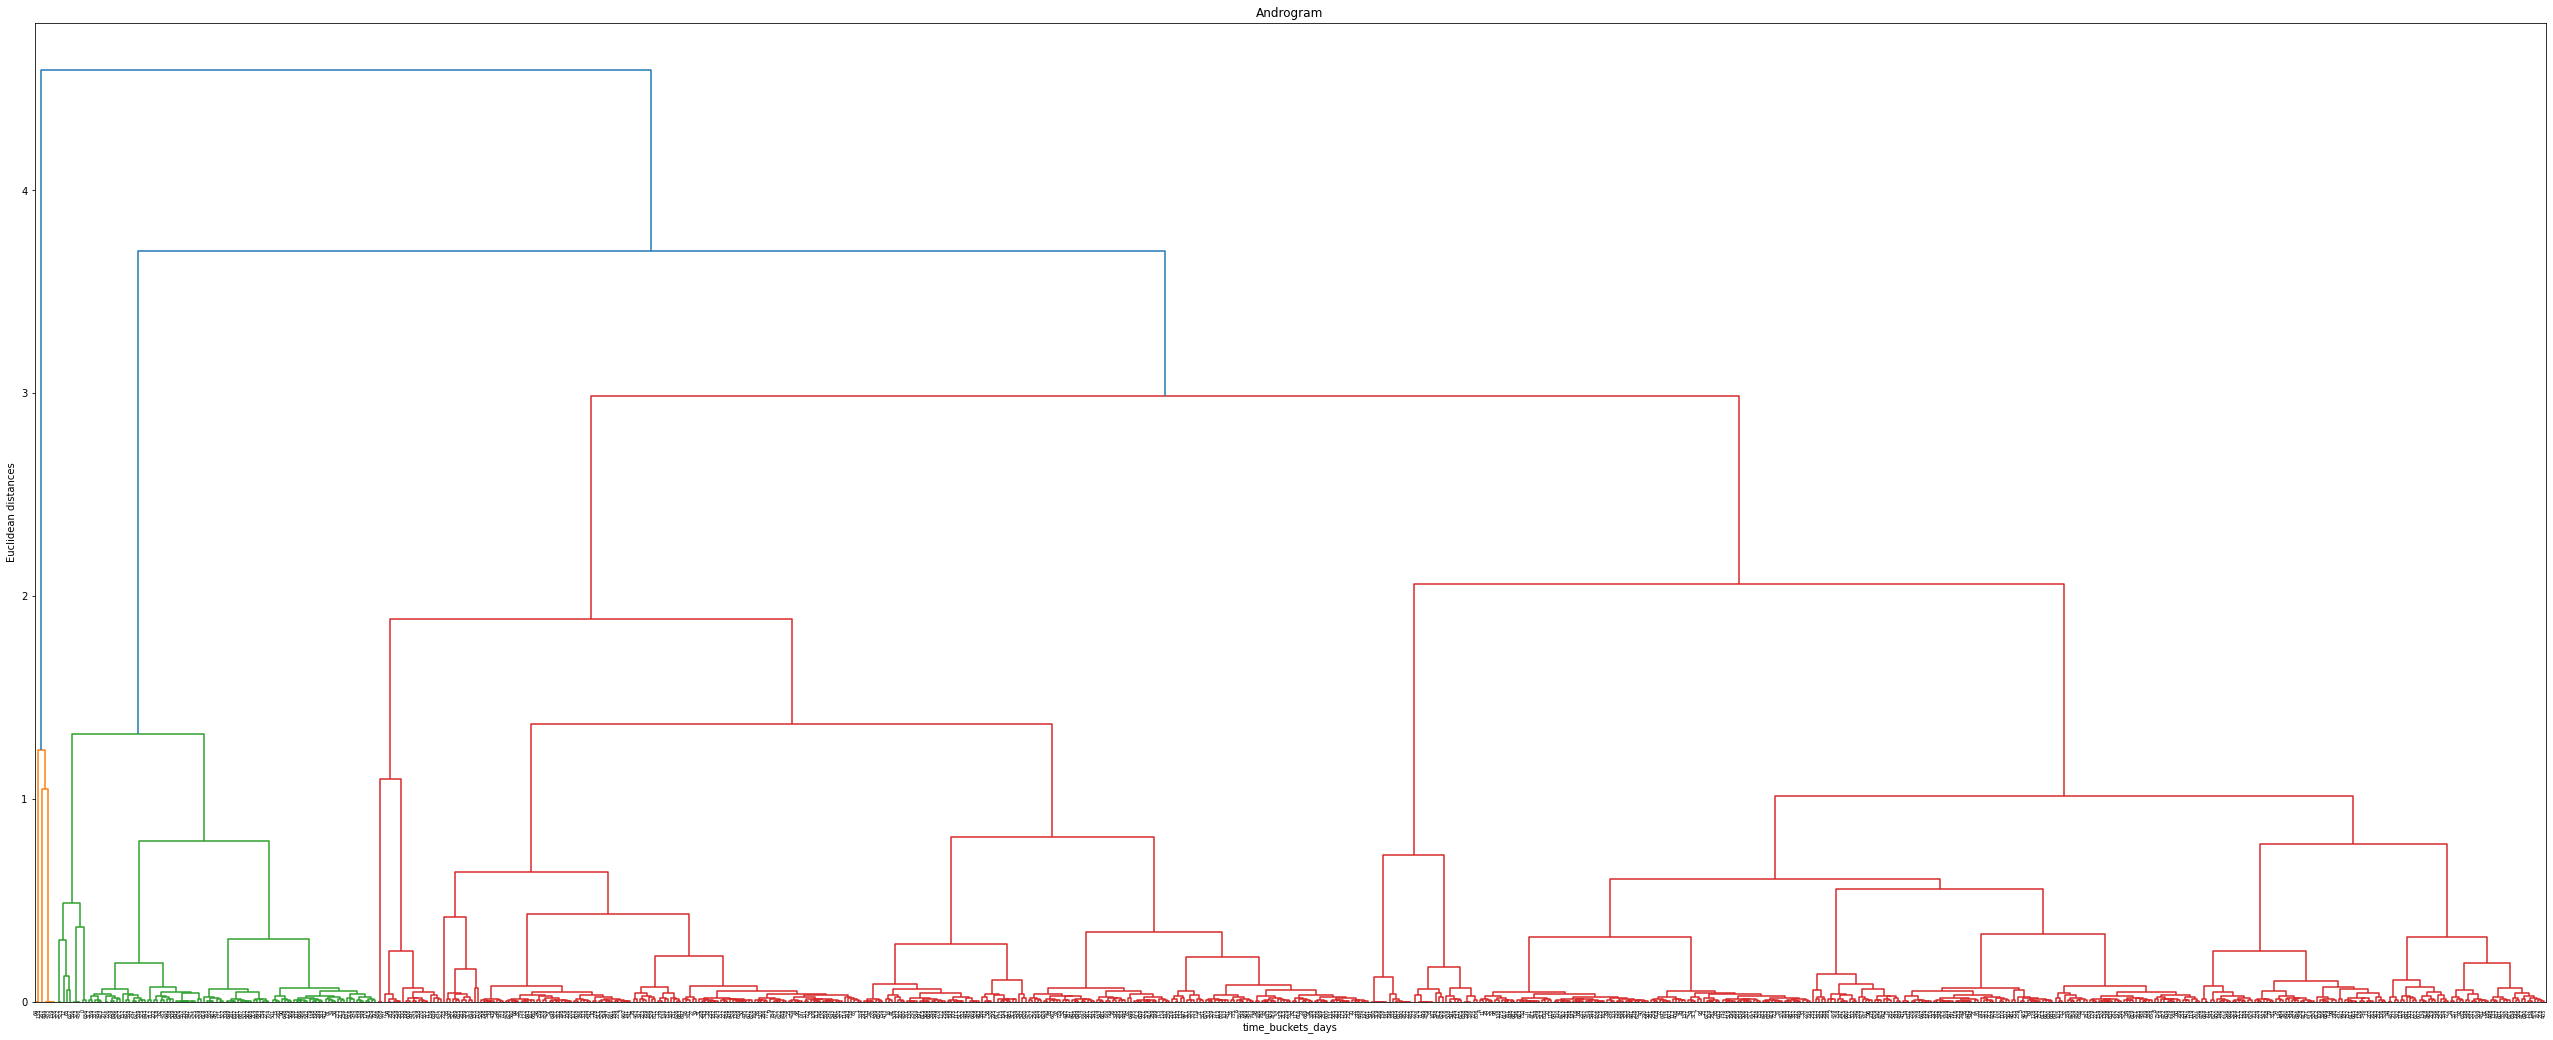

In [26]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(45,18))
plt.title('Androgram')
plt.xlabel('time_buckets_days')
plt.ylabel('Euclidean distances')
#plt.grid(True)
#dendrogram = sch.dendrogram(sch.linkage(crash_data_df[['latitude','longitude']], method = 'ward'))
dendrogram = sch.dendrogram(sch.linkage(group_stats[['latitude_mean', 'latitude_std','longitude_mean', 'longitude_std']], method = 'ward'))
plt.show()

### Based on the dendrogram, there should be 2 clusters of time buckets based on the mean and standard devation. 
the first cluster is very small relative to the second. Perhaps 3 clusters could then be taken as there is quite a lot of difference between the other two big groups.

In [ ]:
from sklearn.mixture import GaussianMixture
X = group_stats[['latitude_mean', 'latitude_std','longitude_mean', 'longitude_std']]
gmm = GaussianMixture(n_components=3, verbose=10, random_state=42)
gmm.fit(X)
labels = gmm.predict(X)
labels = pd.DataFrame(labels,columns=['cluster'])
display(labels.head())
print(labels.shape)
print(group_stats.shape)
group_stats.reset_index(drop=True,inplace=True)
clustered_time_buckets = pd.concat([group_stats,labels], axis=1, ignore_index=True)
display(clustered_time_buckets.head())
plt.scatter(clustered_time_buckets['weekday'], clustered_time_buckets['time_window_str'], c=clustered_time_buckets['cluster'], s=40, cmap='viridis');

Initialization 0
  Iteration 10	 time lapse 0.03310s	 ll change 0.00074
Initialization converged: True	 time lapse 0.03331s	 ll 9.93371


,cluster
0,1
1,2
2,1
3,2
4,0


(807, 1)
(807, 8)


,0,1,2,3,4,5,6,7,8
0,00-03,0,867a45107ffffff,-0.662939,0.000000,37.208730,0.000000,2,1
1,00-03,0,867a6e407ffffff,-1.230609,0.015081,36.881487,0.013531,9,2
2,00-03,0,867a6e40fffffff,-1.219723,0.001615,36.801582,0.000257,2,1
3,00-03,0,867a6e417ffffff,-1.203090,0.007225,36.916658,0.009844,8,2
4,00-03,0,867a6e42fffffff,-1.258459,0.014488,36.819979,0.015277,14,0


KeyError: 'weekday'

In [ ]:
# Number of time buckets in each cluster
display(clustered_time_buckets.groupby('cluster')['RTA_count'].count())
# Number of RTAs in each cluster
display(clustered_time_buckets.groupby('cluster')['RTA_count'].sum())

cluster
0    13
1    41
2     2
Name: RTA_count, dtype: int64

cluster
0    1569
1    4657
2      92
Name: RTA_count, dtype: int64